In this project, we will utilize pandas to analyze data, including value, risk, and return metrics, of the prominent 'FAANG' companies: Facebook, Apple, Amazon, Netflix, and Google. We will address several questions in this notebook:

1. What was the change in our stocks' prices over time?
2. What were the moving averages of our stocks?
3. What were the daily return averages of each stock?
4. What was the correlation between the daily returns of different stocks?
5. How much value do we put at risk by investing in a particular stock?
6. How can we attempt to predict future 'FAANG' stock behavior?

In [82]:
from __future__ import division
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

#Visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from datetime import datetime
#Using yfinance to access Yahoo Historical Stocks
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

We will compare the five "FAANG" companies to analyze their average stock prices and returns. Our objective is to perform a risk assessment of the stocks in the last 365 days.

In [83]:
tickers = ['AAPL','GOOG','MSFT','AMZN','NFLX']

current_time = datetime.now()

# Date one year prior to current
one_year_prior = datetime(current_time.year-1,current_time.month,current_time.day) 

ticker_data = {}
for ticker in tickers:
    ticker_data[ticker] = yf.download(ticker,one_year_prior,current_time)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Here, we have compiled simple statistics regarding the stock price of Netflix in the previous year.

## Tech Stock Analysis: Price, Volume, Moving Averages, and Daily Return Visualization

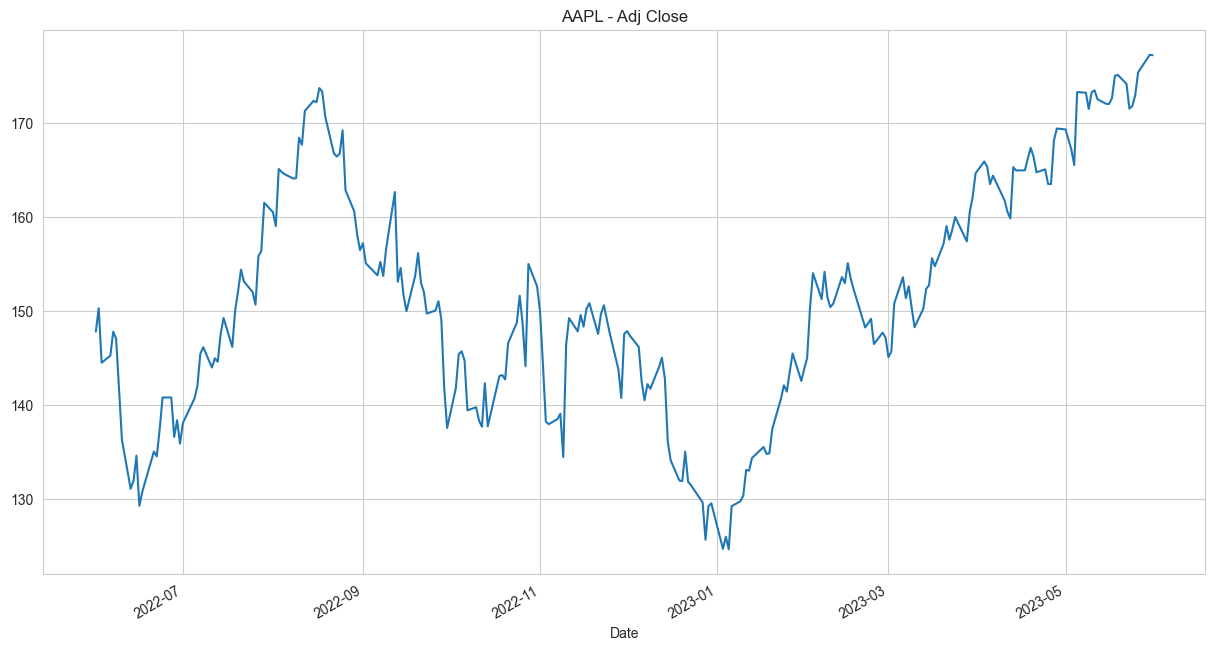

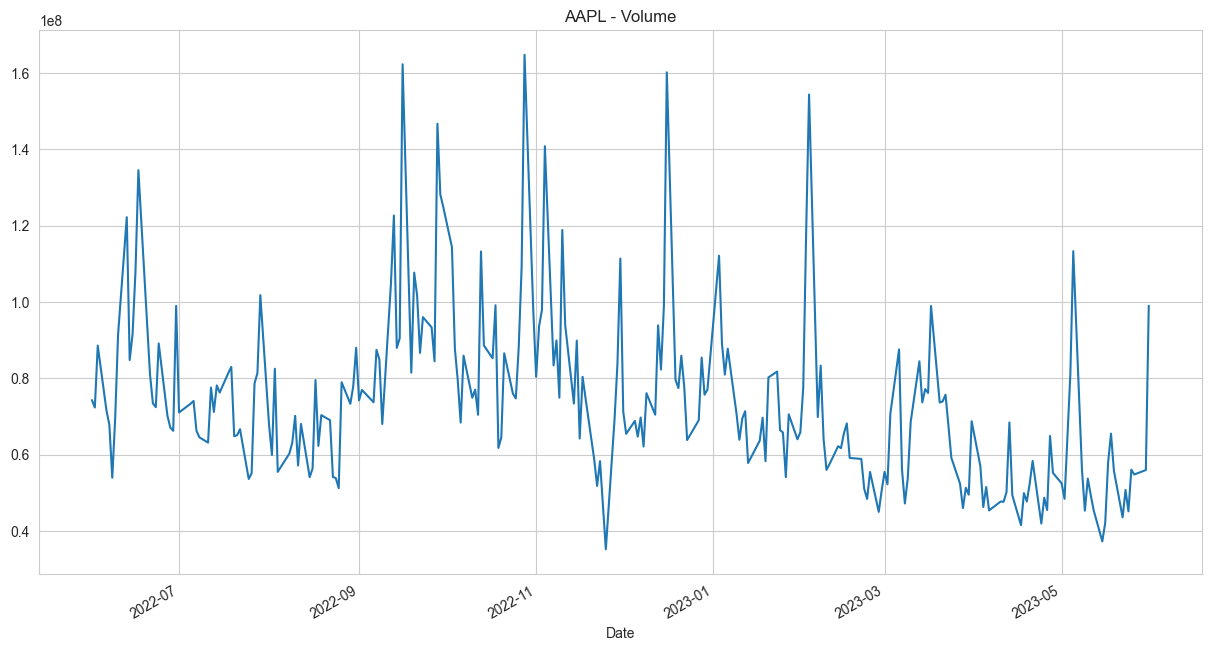

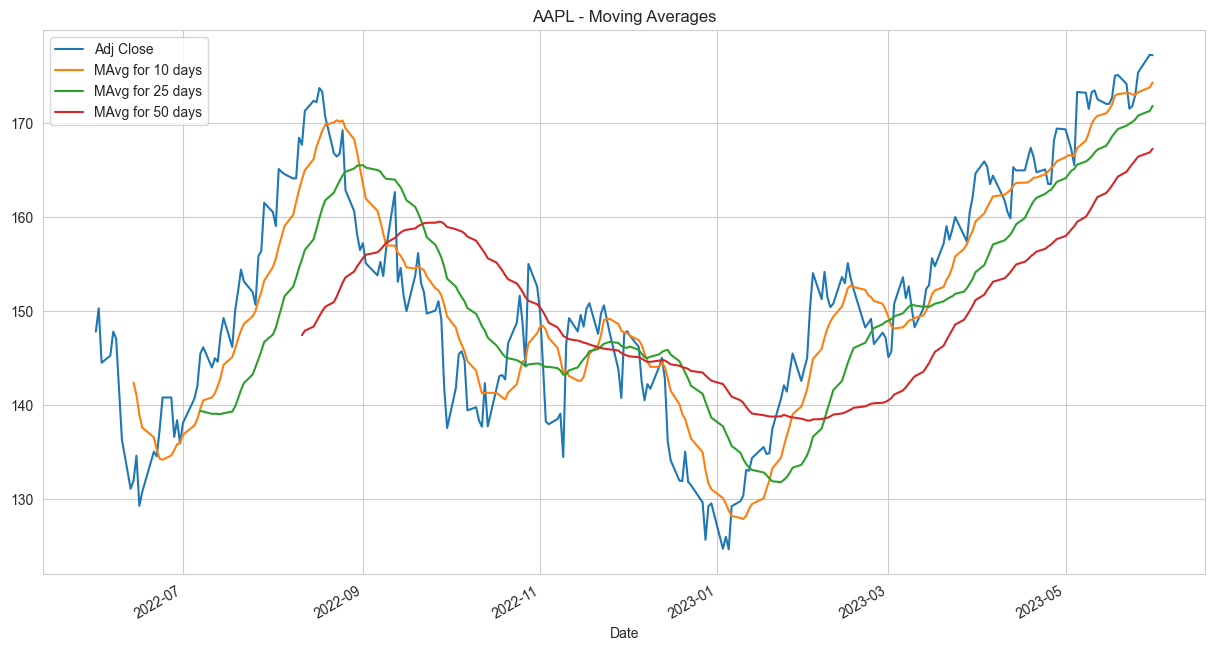

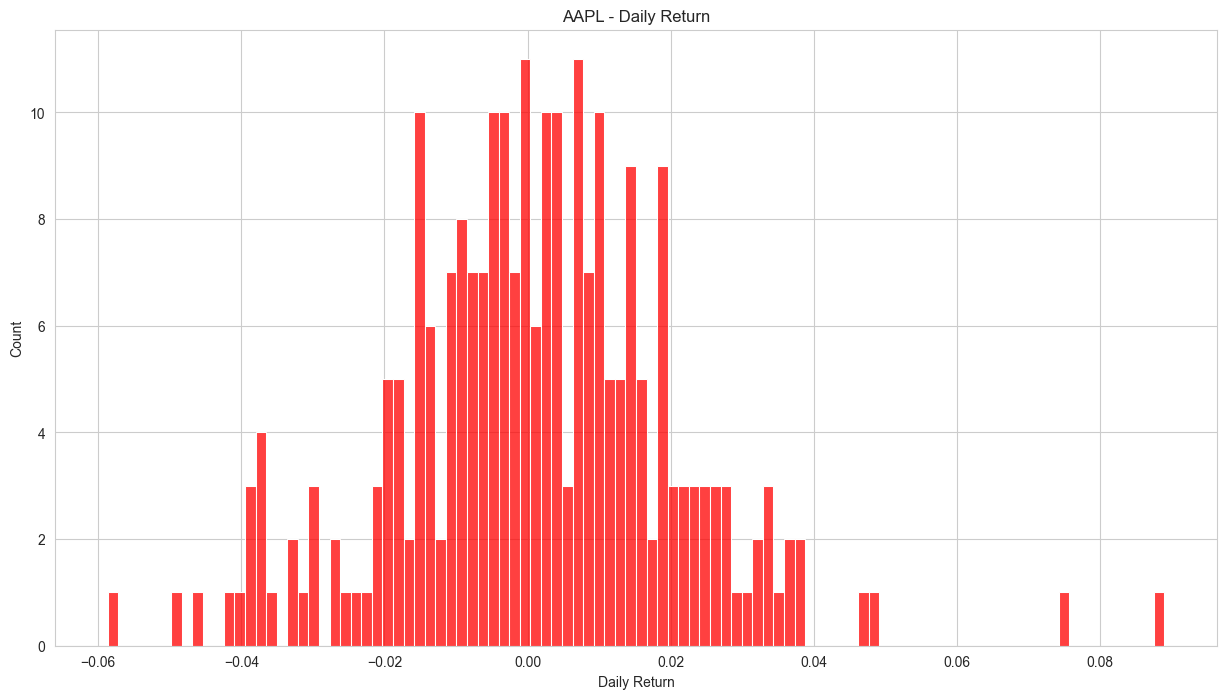

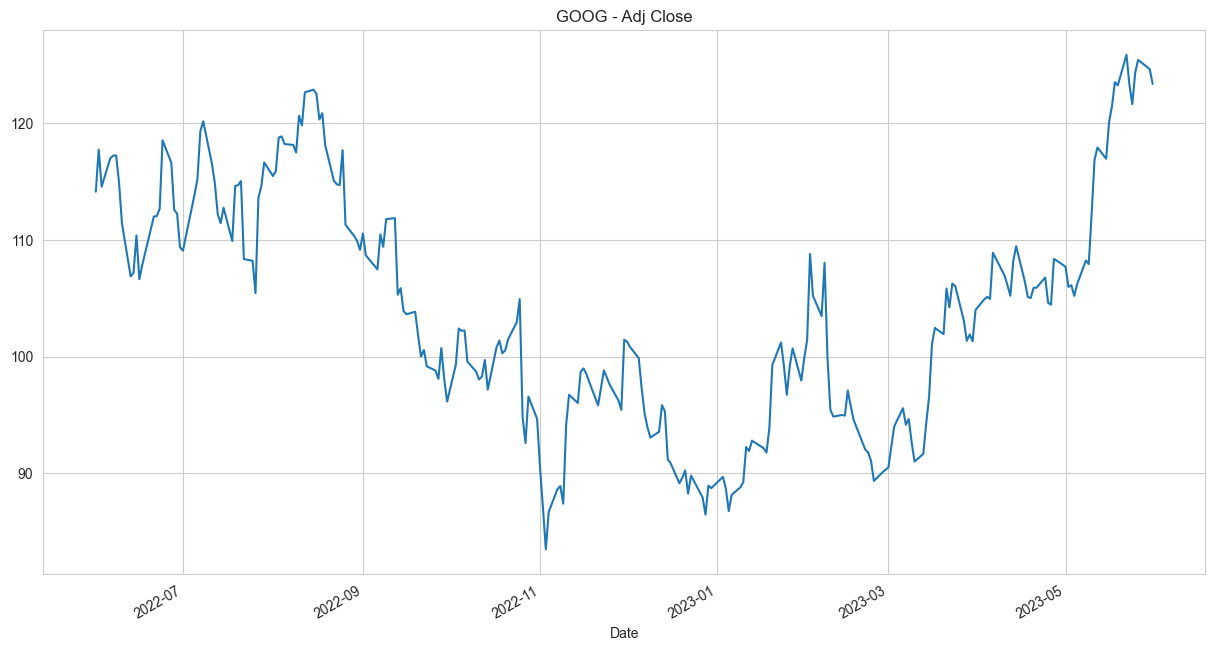

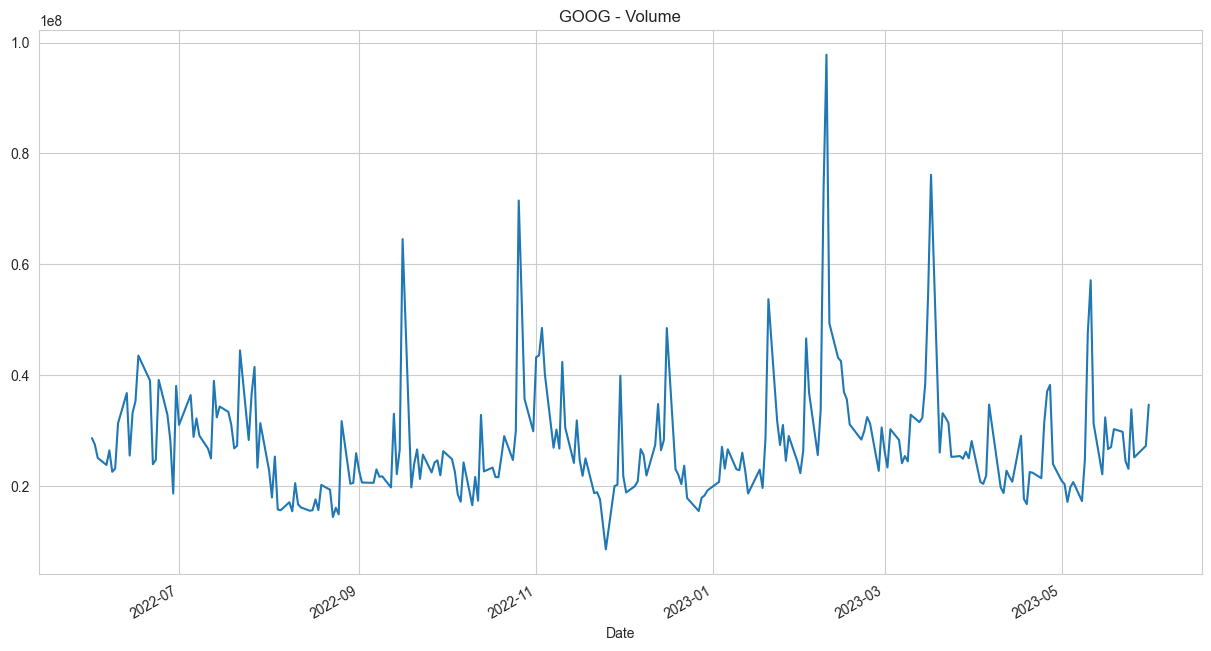

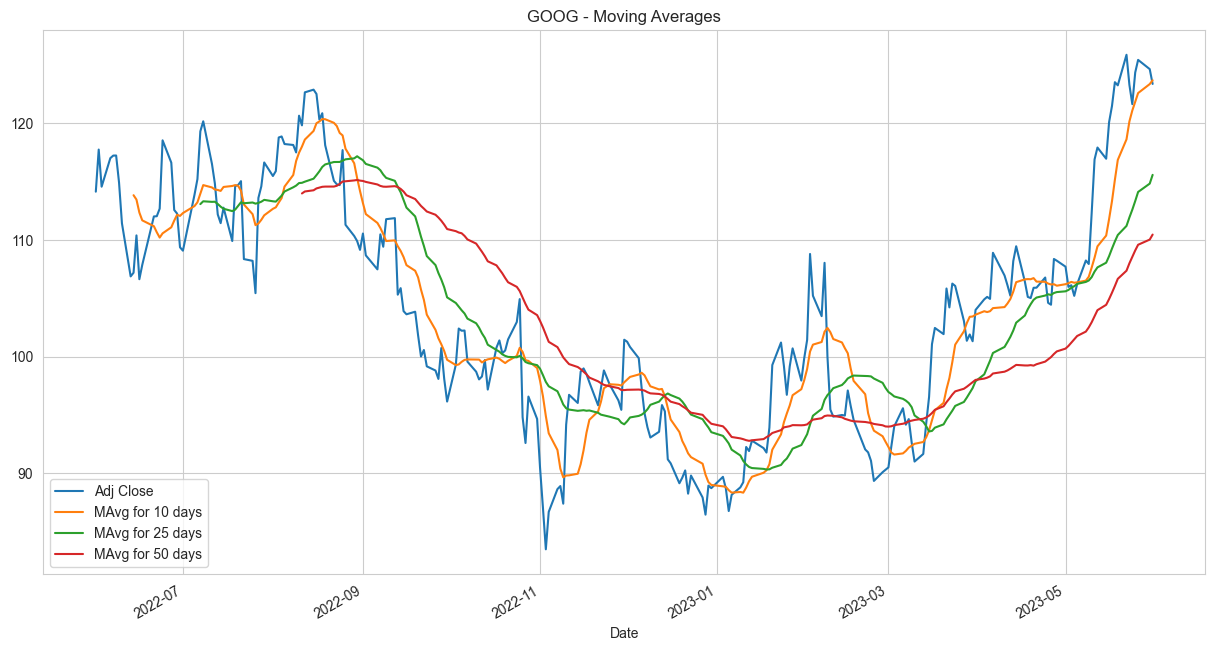

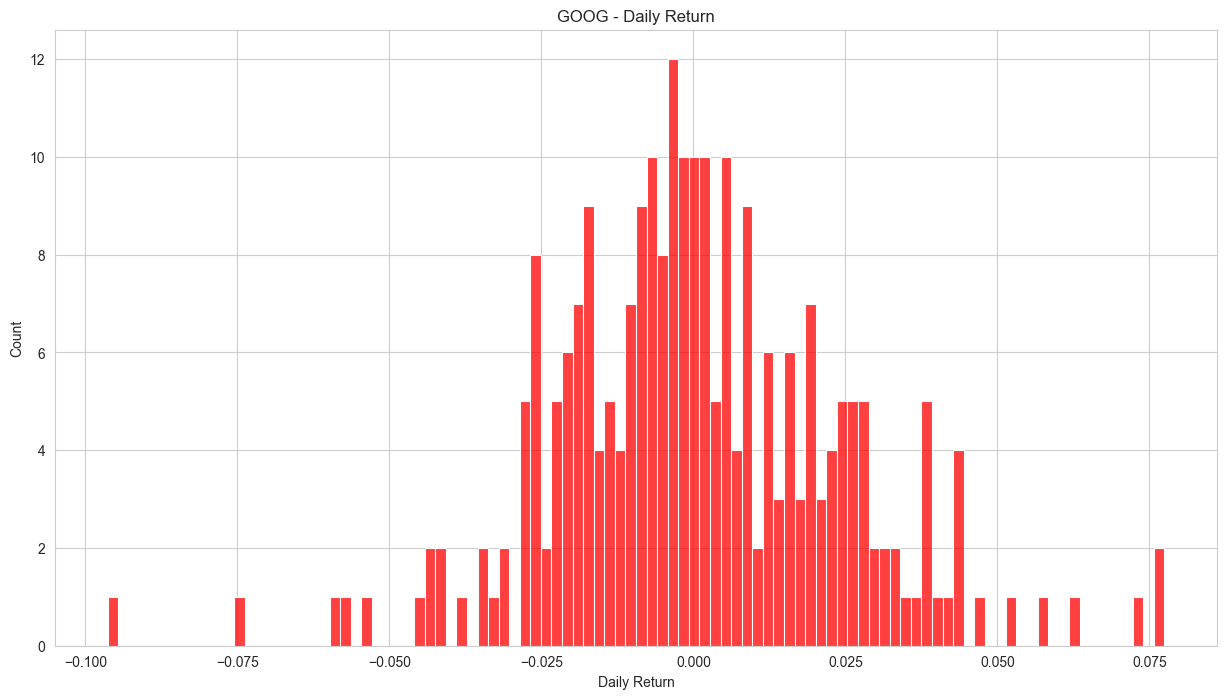

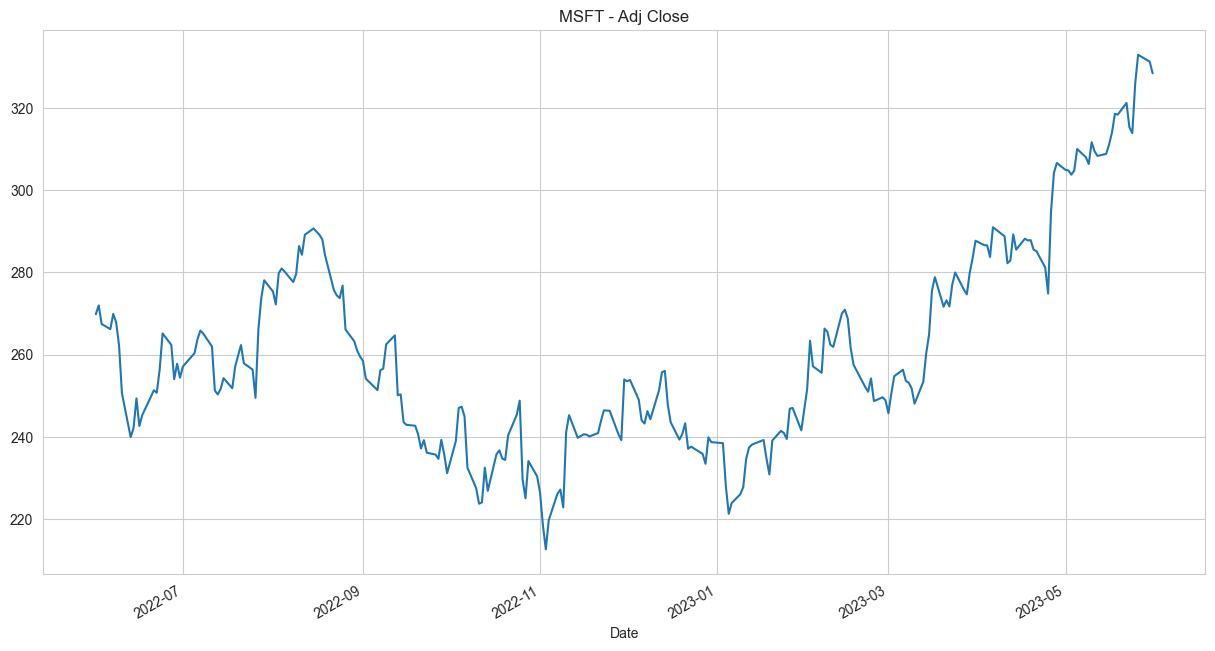

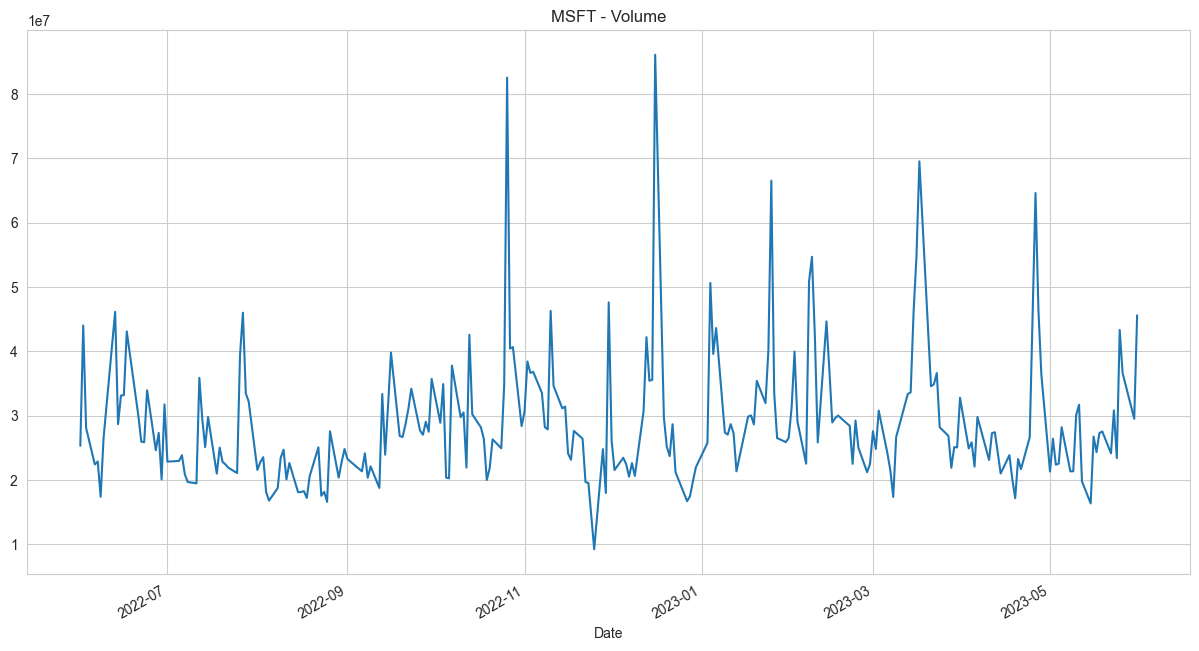

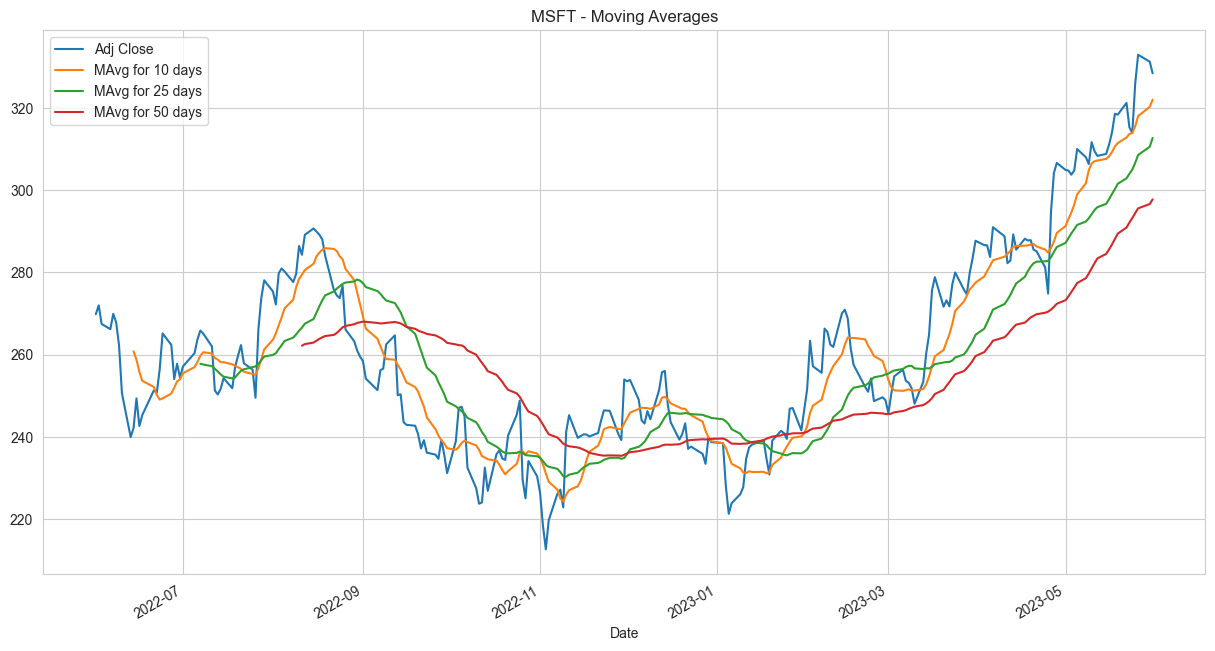

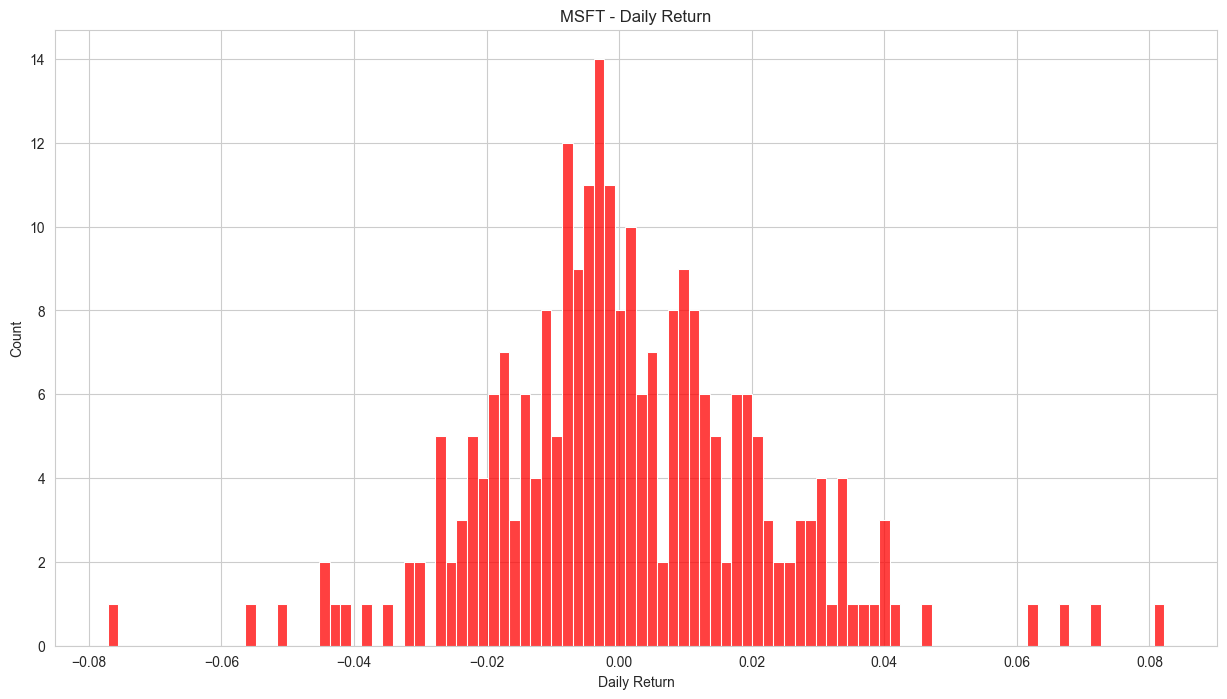

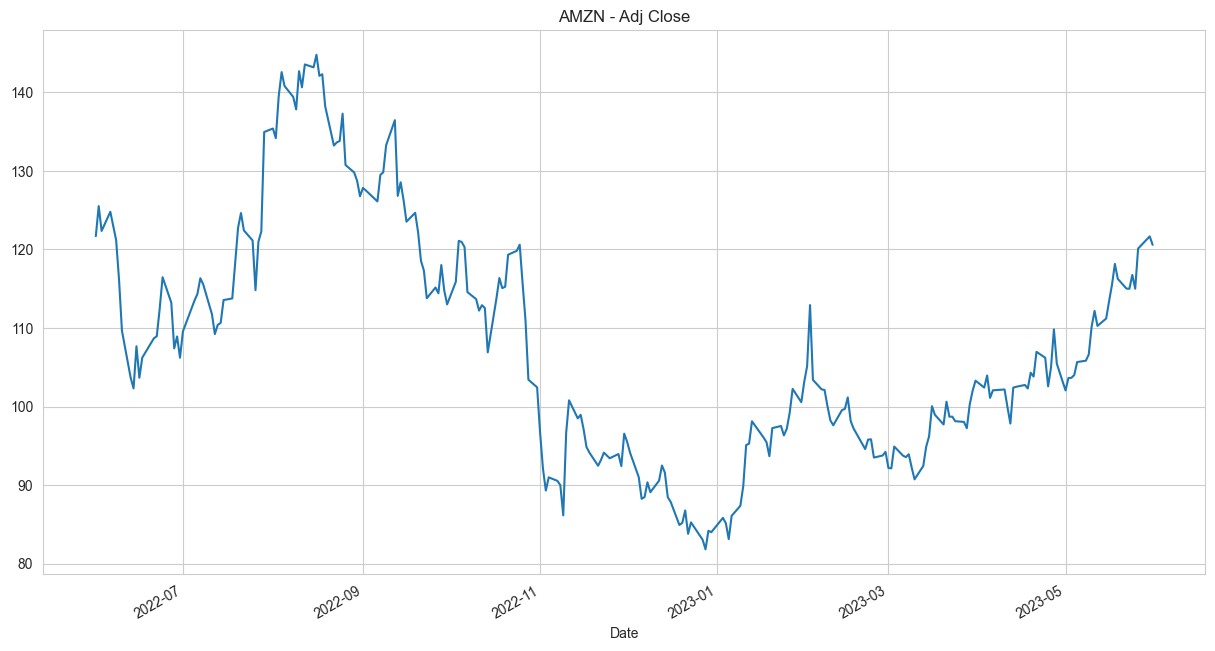

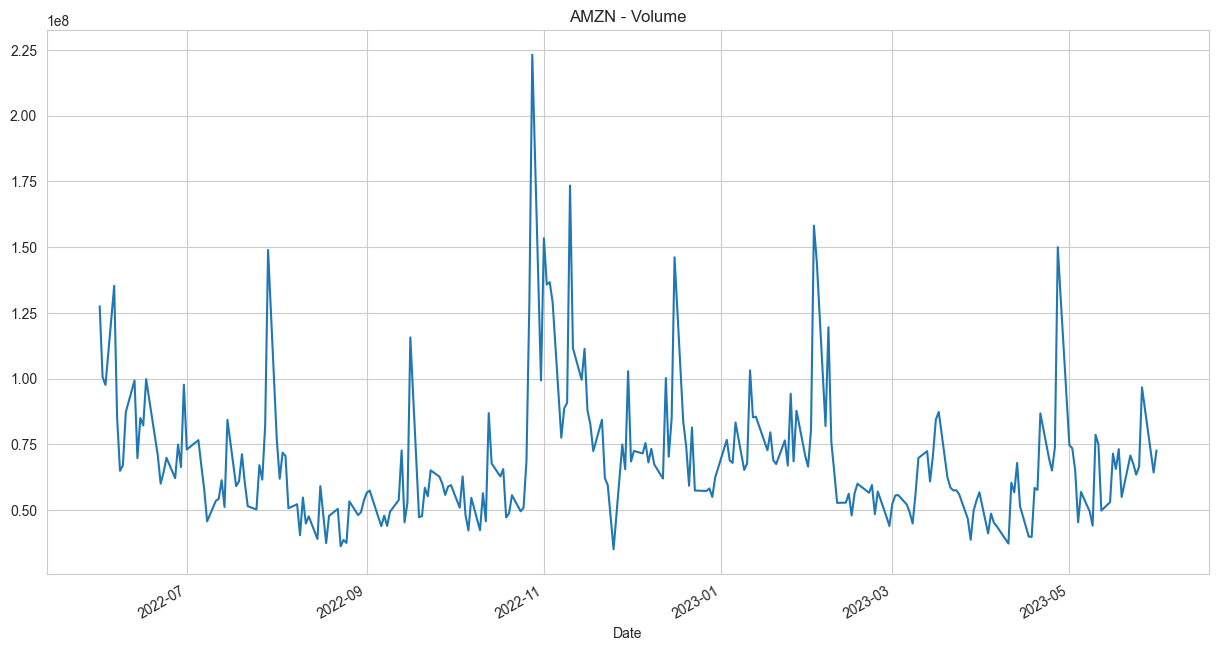

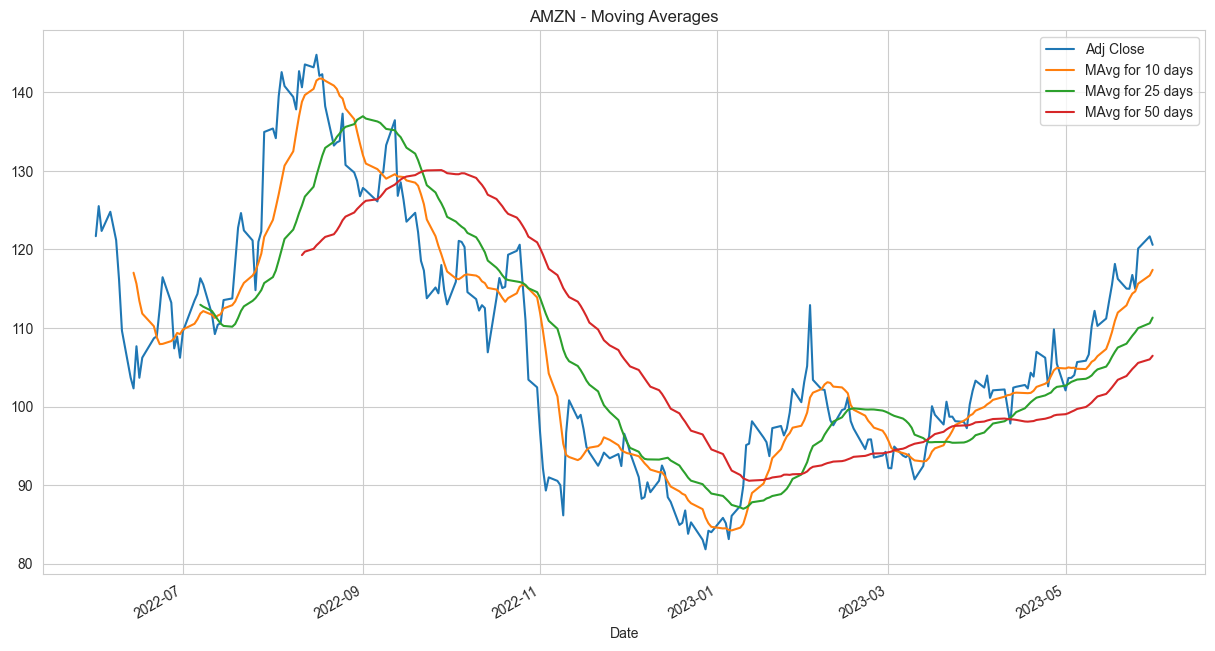

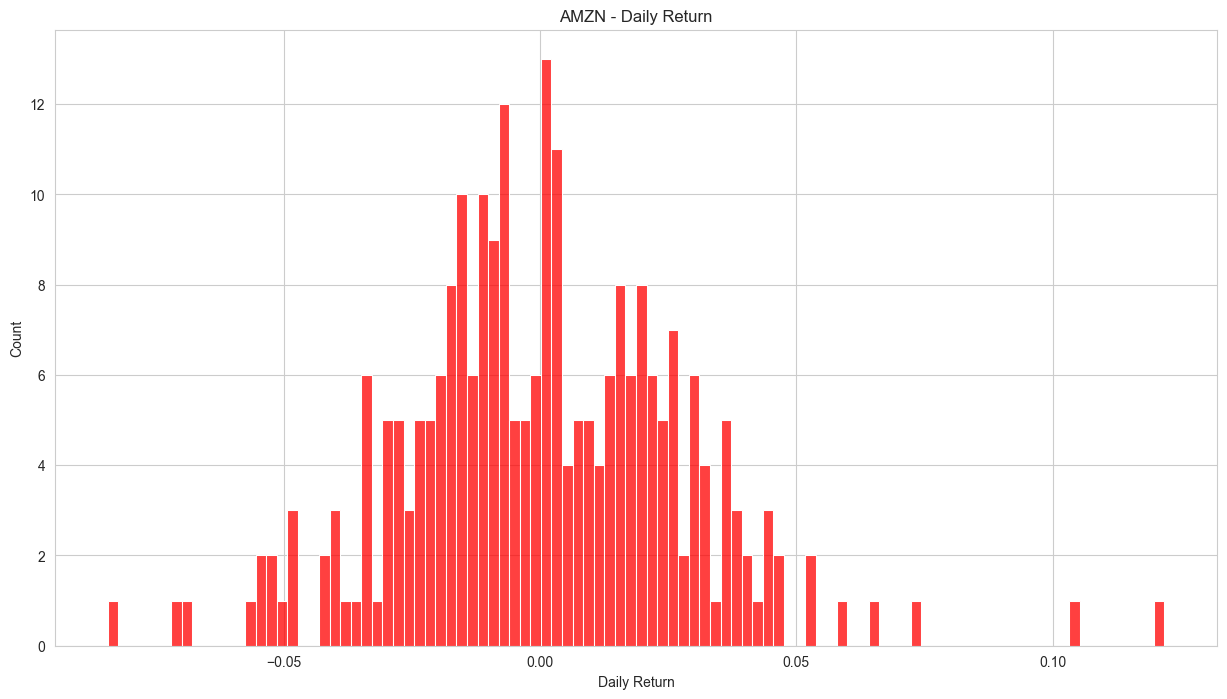

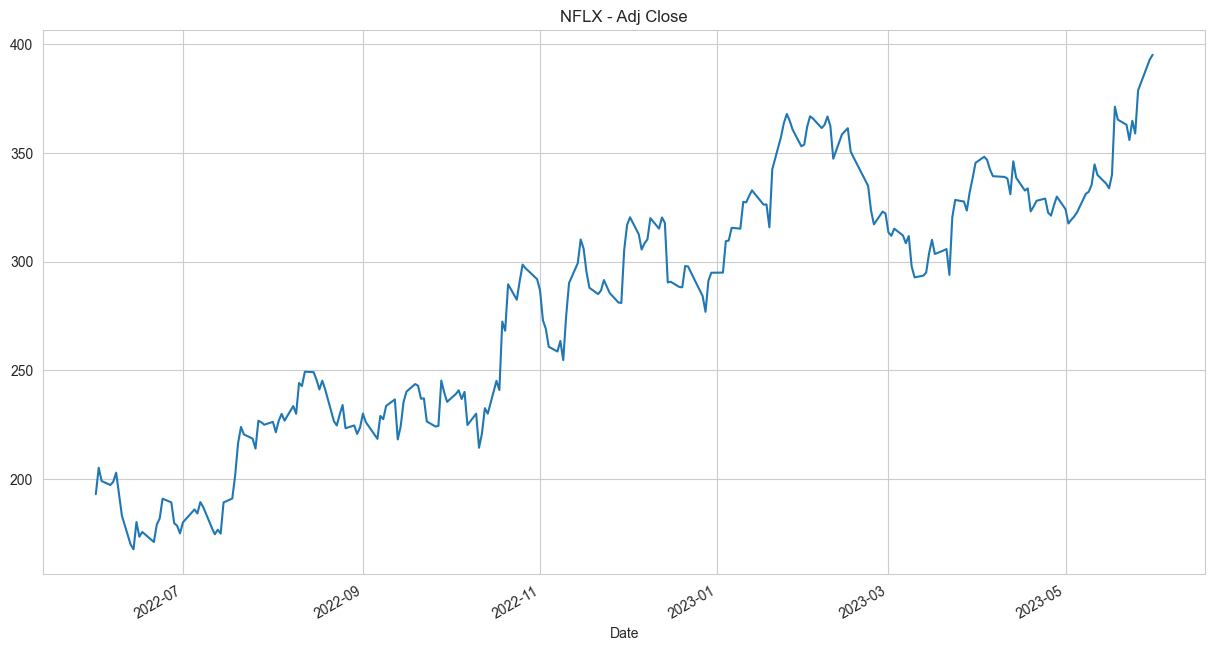

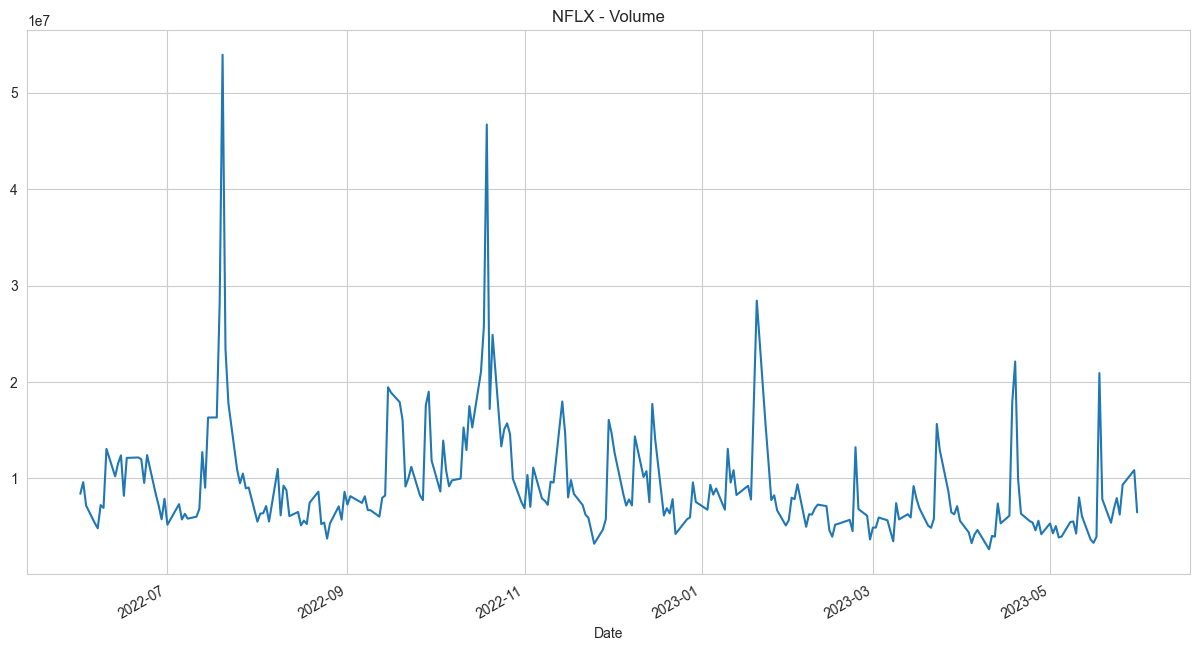

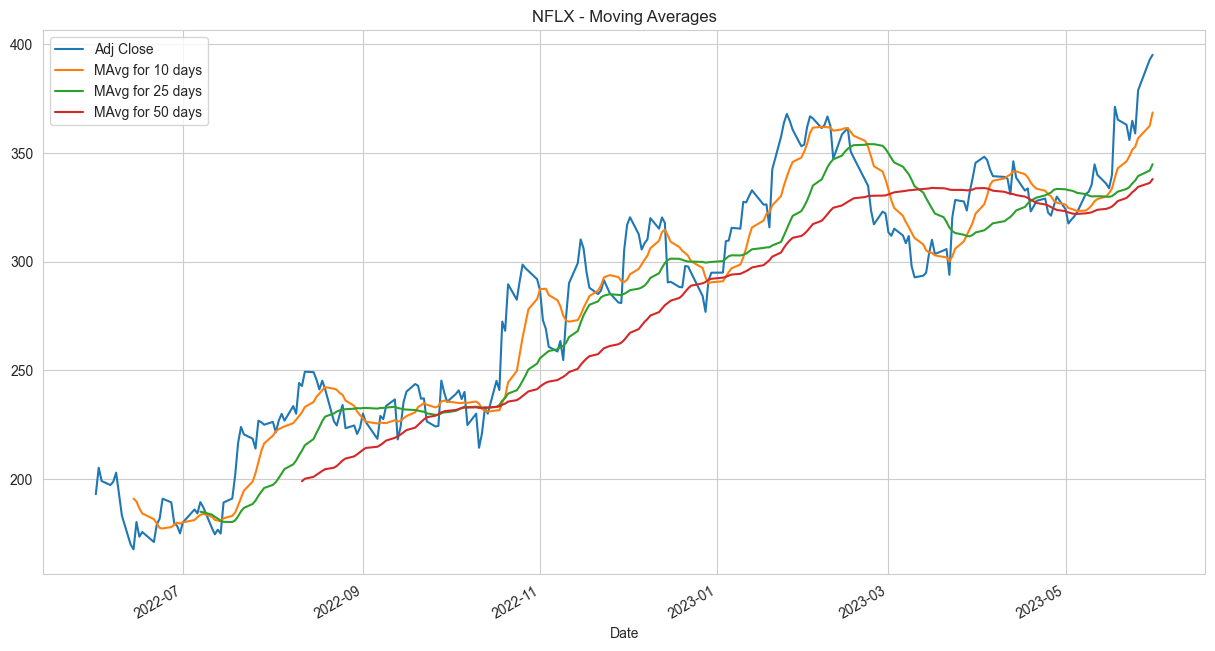

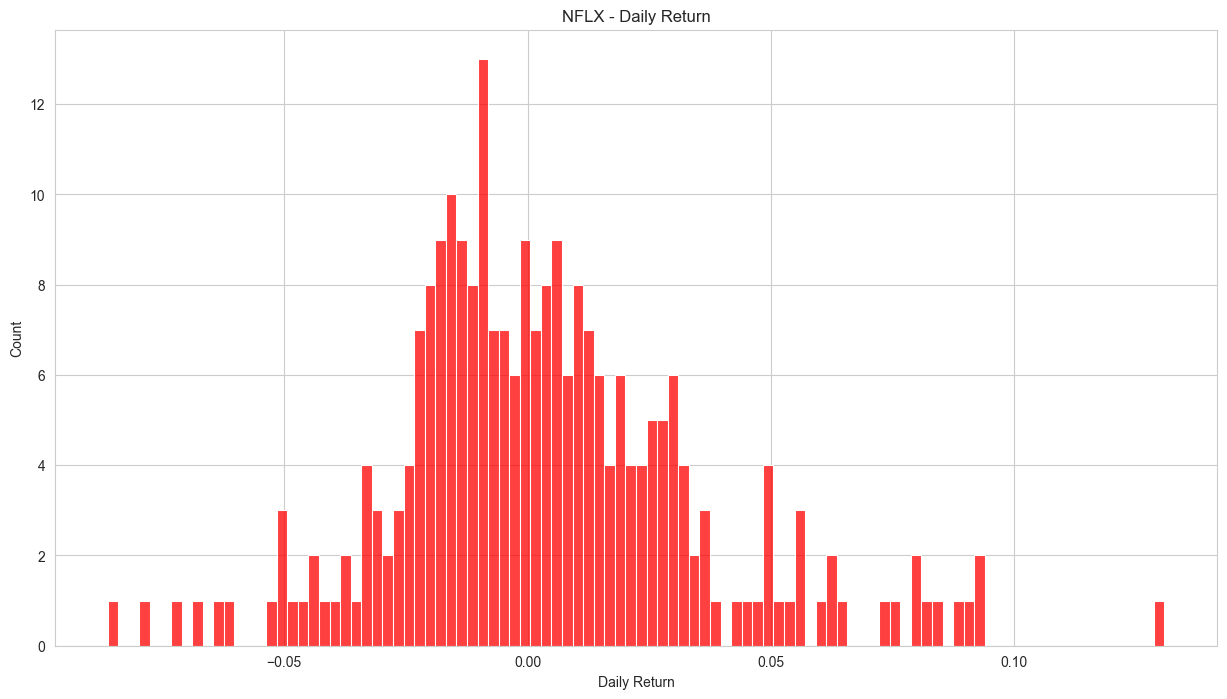

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of averages
averages = [10,25,50]

# Loop through each stock's dataframe
for ticker, df in ticker_data.items():

    # Plot 'Adj Close'
    plt.figure(figsize=(15,8))
    df['Adj Close'].plot()
    plt.title(f'{ticker} - Adj Close')
    plt.show()

    # Plot 'Volume'
    plt.figure(figsize=(15,8))
    df['Volume'].plot()
    plt.title(f'{ticker} - Volume')
    plt.show()

    # Compute moving averages and plot them
    for avg in averages:
        label = f"MAvg for {avg} days"
        df[label] = df['Adj Close'].rolling(window=avg, center=False).mean()

    df[['Adj Close', 'MAvg for 10 days', 'MAvg for 25 days', 'MAvg for 50 days']].plot(figsize=(15,8))
    plt.title(f'{ticker} - Moving Averages')
    plt.show()

    # Compute daily return
    df['Daily Return'] = df['Adj Close'].pct_change()

    # Plot 'Daily Return'
    plt.figure(figsize=(15,8))
    sns.histplot(df['Daily Return'].dropna(), bins=100, color='red')
    plt.title(f'{ticker} - Daily Return')
    plt.show()

In [85]:
rets_compr = pd.DataFrame()

for ticker in ticker_data:
    rets_compr[ticker] = ticker_data[ticker]['Adj Close'].pct_change()


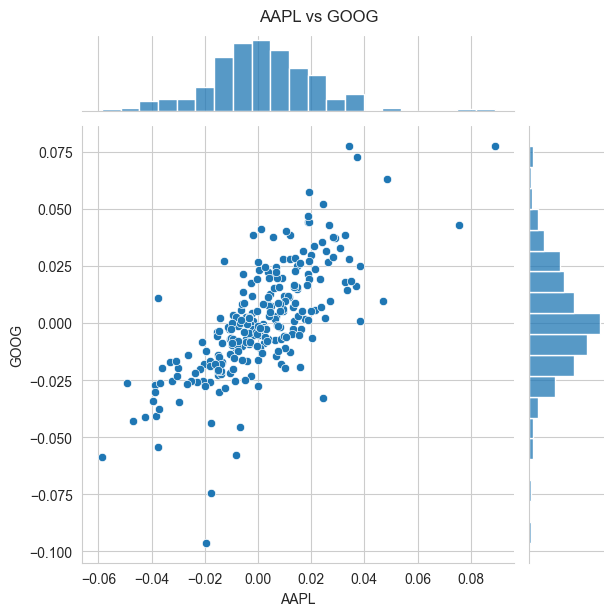

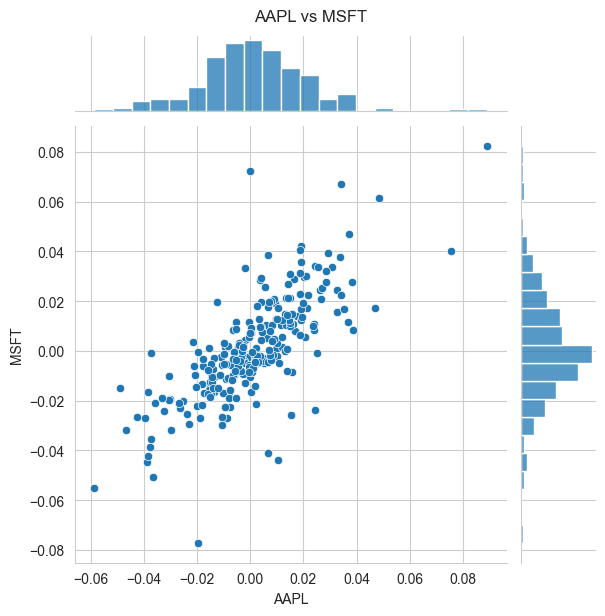

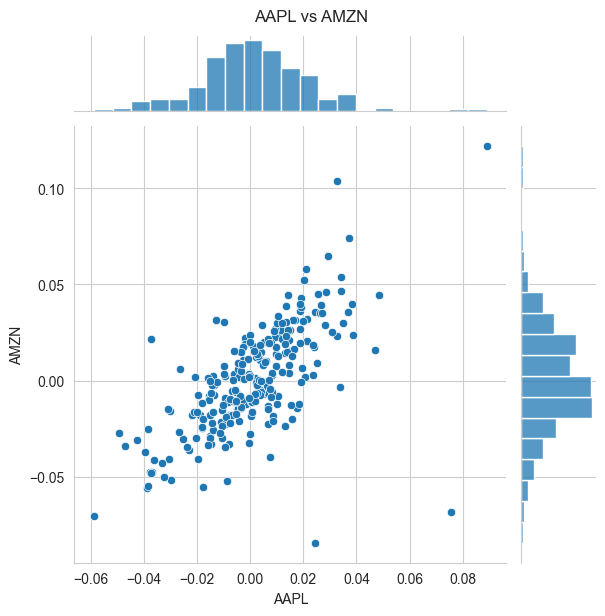

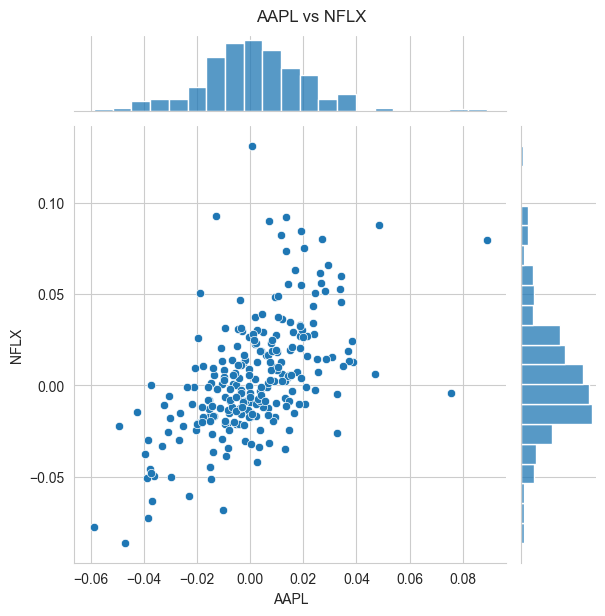

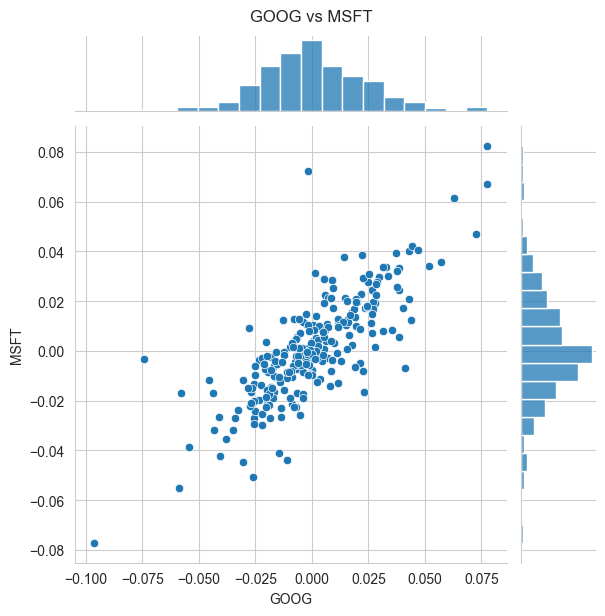

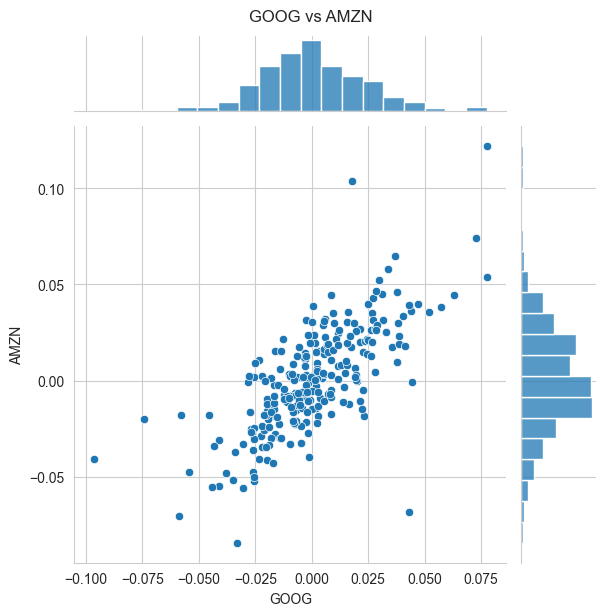

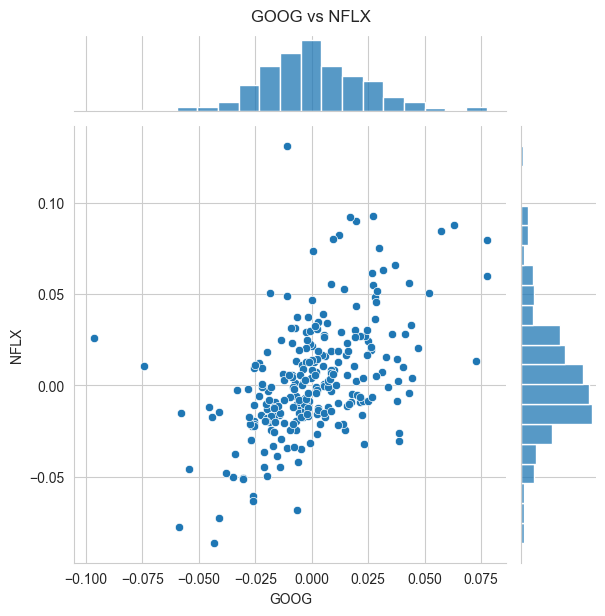

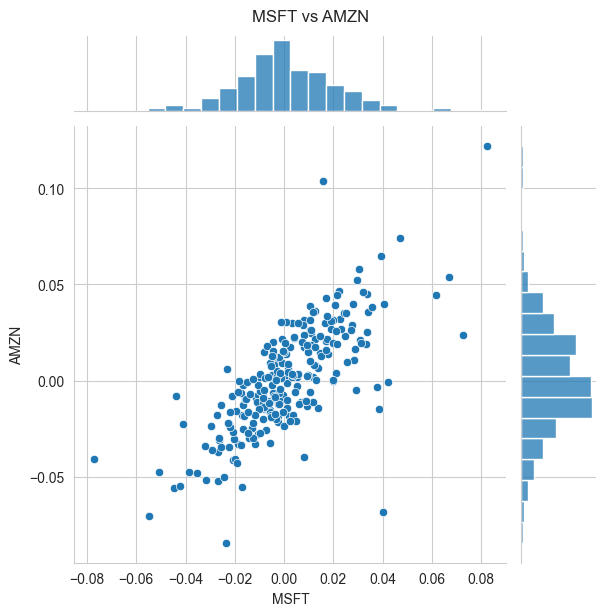

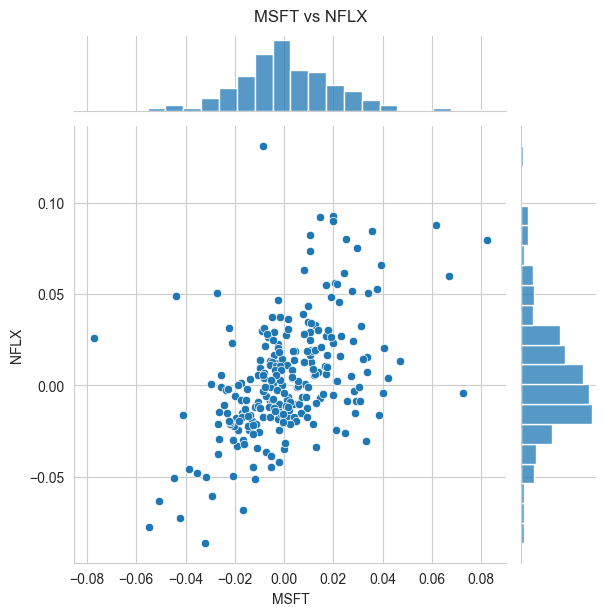

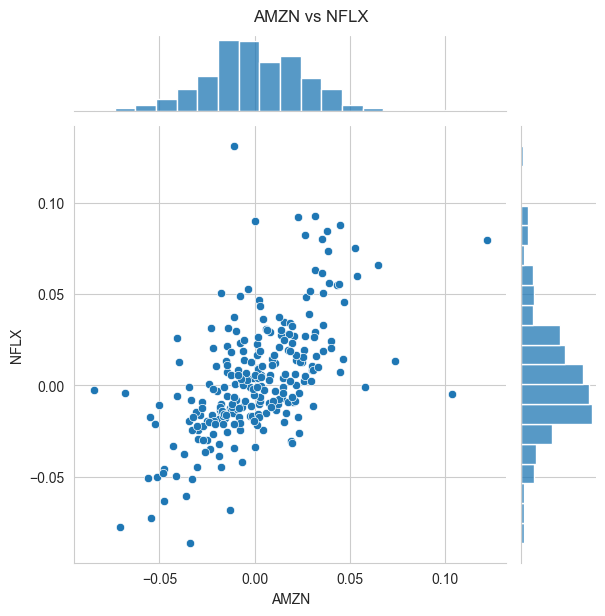

In [86]:
# Assuming rets_compr is the dataframe where you stored the daily returns
for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        sns.jointplot(x=tickers[i], y=tickers[j], data=rets_compr, kind='scatter')
        plt.suptitle(f'{tickers[i]} vs {tickers[j]}', y=1.02)
        plt.show()

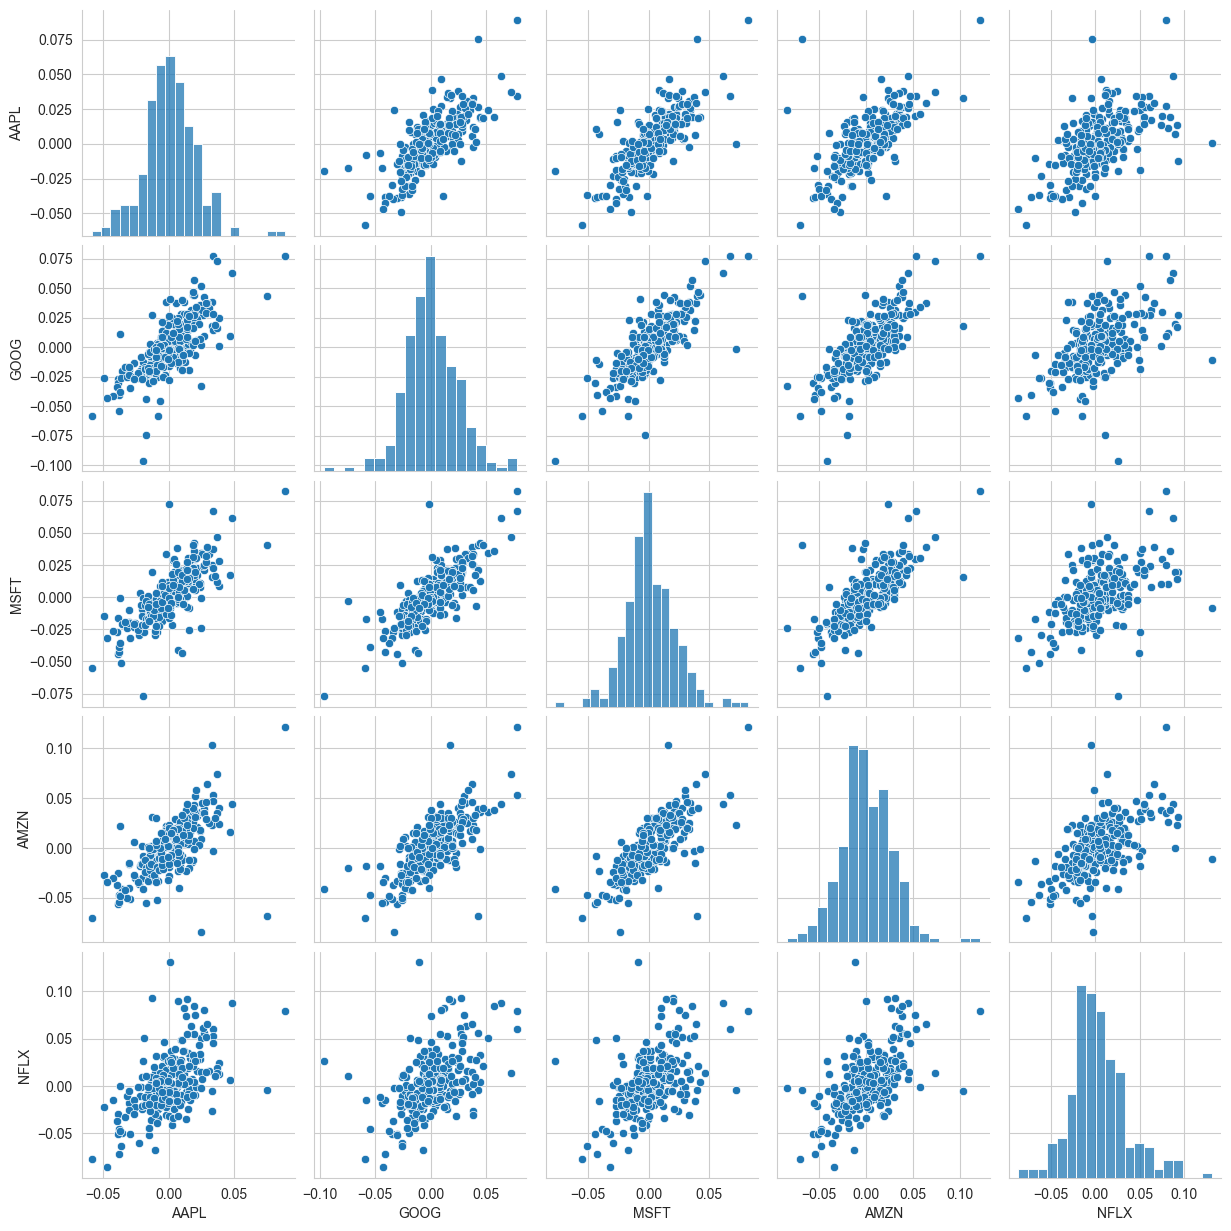

In [87]:
sns.pairplot(rets_compr.dropna())

          AAPL      GOOG      MSFT      AMZN      NFLX
AAPL  1.000000  0.729002  0.750975  0.669613  0.563385
GOOG  0.729002  1.000000  0.797450  0.723329  0.509753
MSFT  0.750975  0.797450  1.000000  0.735054  0.495282
AMZN  0.669613  0.723329  0.735054  1.000000  0.583521
NFLX  0.563385  0.509753  0.495282  0.583521  1.000000


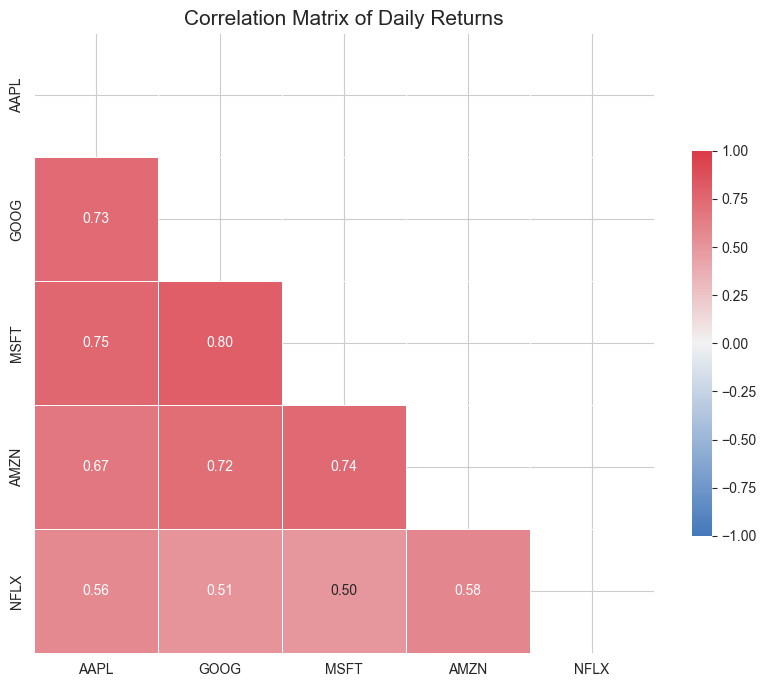

In [88]:
# Assuming rets_compr is the dataframe where you stored the daily returns
correlation_matrix = rets_compr.corr()
print(correlation_matrix)

# Create a mask to only show the lower triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Initialize matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Create a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.title('Correlation Matrix of Daily Returns', fontsize=15)
plt.show()


## Random Forest to Predict Adj Close 

In [89]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

MAE_results = {}

# For each stock
for ticker, df in ticker_data.items():
    # Create x and y
    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    randomForestModel = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
    randomForestModel.fit(x_train, y_train)

    # Predict the stock prices
    predict = randomForestModel.predict(x_test)

    # Calculate mean absolute error
    mean_absolute_error = round(np.mean(np.abs(predict - y_test)), 2)

    # Store the results in the accuracy_results dictionary
    if ticker not in MAE_results:
        MAE_results[ticker] = {}
    MAE_results[ticker]['RandomForest'] = mean_absolute_error

# Print the results
for ticker, models in MAE_results.items():
    for model, accuracy in models.items():
        print(f"{ticker} Predictions with {model}: Mean absolute error: {accuracy}")



AAPL Predictions with RandomForest: Mean absolute error: 2.51
GOOG Predictions with RandomForest: Mean absolute error: 2.15
MSFT Predictions with RandomForest: Mean absolute error: 4.74
AMZN Predictions with RandomForest: Mean absolute error: 2.57
NFLX Predictions with RandomForest: Mean absolute error: 8.33


## SVM to Predict Adj Close

In [90]:
from sklearn.svm import SVR

# Initialize the accuracy results dictionary if not already initialized
if 'accuracy_results' not in globals():
    MAE_results = {}

# For each stock
for ticker, df in ticker_data.items():
    
    # Create x and y
    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    SVRmodel = SVR(kernel='rbf')
    SVRmodel.fit(x_train, y_train)

    # Predict the stock prices
    predict = SVRmodel.predict(x_test)

    # # Calculate accuracy
    # accuracy = round(100 - np.mean(100 * (abs(predict - y_test) / y_test)), 2)


    mean_absolute_error = round(np.mean(np.abs(predict - y_test)), 2)

    # Store accuracy into the dictionary
    if ticker not in MAE_results:
        MAE_results[ticker] = {}
    
    MAE_results[ticker]['SVR'] = mean_absolute_error

# Print metrics
for ticker, models in MAE_results.items():
    for model, accuracy in models.items():
        print(f"{ticker} Predictions with {model}: Mean absolute error: {accuracy}")


AAPL Predictions with RandomForest: Mean absolute error: 2.51
AAPL Predictions with SVR: Mean absolute error: 2.68
GOOG Predictions with RandomForest: Mean absolute error: 2.15
GOOG Predictions with SVR: Mean absolute error: 2.29
MSFT Predictions with RandomForest: Mean absolute error: 4.74
MSFT Predictions with SVR: Mean absolute error: 7.91
AMZN Predictions with RandomForest: Mean absolute error: 2.57
AMZN Predictions with SVR: Mean absolute error: 2.77
NFLX Predictions with RandomForest: Mean absolute error: 8.33
NFLX Predictions with SVR: Mean absolute error: 17.63


## KNeighborsRegressor to Predict Adj Close

In [91]:
from sklearn.neighbors import KNeighborsRegressor

# For each stock
for ticker, df in ticker_data.items():

    # Create x and y
    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    neigh = KNeighborsRegressor(n_neighbors=2)
    neigh.fit(x_train, y_train)

    # Predict the stock prices
    predict = neigh.predict(x_test)

    # Calculate mean absolute error
    mean_absolute_error = round(np.mean(np.abs(predict - y_test)), 2)
    
    # Store the results in the accuracy_results dictionary
    if ticker not in MAE_results:
        MAE_results[ticker] = {}
    MAE_results[ticker]['KNeighbors'] = mean_absolute_error

# Print the results
for ticker, models in MAE_results.items():
    for model, accuracy in models.items():
        print(f"{ticker} Predictions with {model}: Mean absolute error: {accuracy}")


AAPL Predictions with RandomForest: Mean absolute error: 2.51
AAPL Predictions with SVR: Mean absolute error: 2.68
AAPL Predictions with KNeighbors: Mean absolute error: 2.48
GOOG Predictions with RandomForest: Mean absolute error: 2.15
GOOG Predictions with SVR: Mean absolute error: 2.29
GOOG Predictions with KNeighbors: Mean absolute error: 2.32
MSFT Predictions with RandomForest: Mean absolute error: 4.74
MSFT Predictions with SVR: Mean absolute error: 7.91
MSFT Predictions with KNeighbors: Mean absolute error: 4.69
AMZN Predictions with RandomForest: Mean absolute error: 2.57
AMZN Predictions with SVR: Mean absolute error: 2.77
AMZN Predictions with KNeighbors: Mean absolute error: 2.59
NFLX Predictions with RandomForest: Mean absolute error: 8.33
NFLX Predictions with SVR: Mean absolute error: 17.63
NFLX Predictions with KNeighbors: Mean absolute error: 9.39


## Gradient Boosting to Predict Adj Close

In [92]:
from sklearn.ensemble import GradientBoostingRegressor

# For each stock
for ticker, df in ticker_data.items():

    # Create x and y
    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    gb_regressor = GradientBoostingRegressor()
    gb_regressor.fit(x_train, y_train)

    # Predict the stock prices
    predict = gb_regressor.predict(x_test)

    # Calculate mean absolute error
    mean_absolute_error = round(np.mean(np.abs(predict - y_test)), 2)

    # Store the results in the accuracy_results dictionary
    if ticker not in MAE_results:
        MAE_results[ticker] = {}
    MAE_results[ticker]['GradientBoosting'] = mean_absolute_error

# Print the results
for ticker, models in MAE_results.items():
    for model, accuracy in models.items():
        print(f"{ticker} Predictions with {model}: Mean absolute error: {accuracy}")


AAPL Predictions with RandomForest: Mean absolute error: 2.51
AAPL Predictions with SVR: Mean absolute error: 2.68
AAPL Predictions with KNeighbors: Mean absolute error: 2.48
AAPL Predictions with GradientBoosting: Mean absolute error: 2.55
GOOG Predictions with RandomForest: Mean absolute error: 2.15
GOOG Predictions with SVR: Mean absolute error: 2.29
GOOG Predictions with KNeighbors: Mean absolute error: 2.32
GOOG Predictions with GradientBoosting: Mean absolute error: 2.28
MSFT Predictions with RandomForest: Mean absolute error: 4.74
MSFT Predictions with SVR: Mean absolute error: 7.91
MSFT Predictions with KNeighbors: Mean absolute error: 4.69
MSFT Predictions with GradientBoosting: Mean absolute error: 5.0
AMZN Predictions with RandomForest: Mean absolute error: 2.57
AMZN Predictions with SVR: Mean absolute error: 2.77
AMZN Predictions with KNeighbors: Mean absolute error: 2.59
AMZN Predictions with GradientBoosting: Mean absolute error: 2.61
NFLX Predictions with RandomForest: M

## LSTM to predict Adj Close

In [94]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# For each stock
for ticker, df in ticker_data.items():
    
    # Create x and y
    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Reshape the data for LSTM
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the LSTM model
    model.fit(x_train, y_train, epochs=50, batch_size=32)

    # Make predictions
    predict = model.predict(x_test)

    # Calculate mean absolute error
    mean_absolute_error = round(np.mean(np.abs(predict - y_test)), 2)

    # Store the results in the accuracy_results dictionary
    if ticker not in MAE_results:
        MAE_results[ticker] = {}
    MAE_results[ticker]['LSTM'] = mean_absolute_error

# Print the results
for ticker, models in MAE_results.items():
    for model, accuracy in models.items():
        print(f"{ticker} Predictions with {model}: Mean absolute error: {accuracy}")



Epoch 1/50
6/6 [==============================] - 5s 7ms/step - loss: 23292.6719
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 23233.0352
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 23133.2441
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 22939.7461
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 22548.5195
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 21907.8262
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 21168.1465
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 20574.4492
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 20201.4570
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 19972.7266
Epoch 11/50
6/6 [==============================] - 0s 7ms/step - loss: 19808.2207
Epoch 12/50
6/6 [==============================] - 0s 7ms/step - loss: 19669.1250
Epoch 13/50
6/6 [========

## Comparison of different approaches

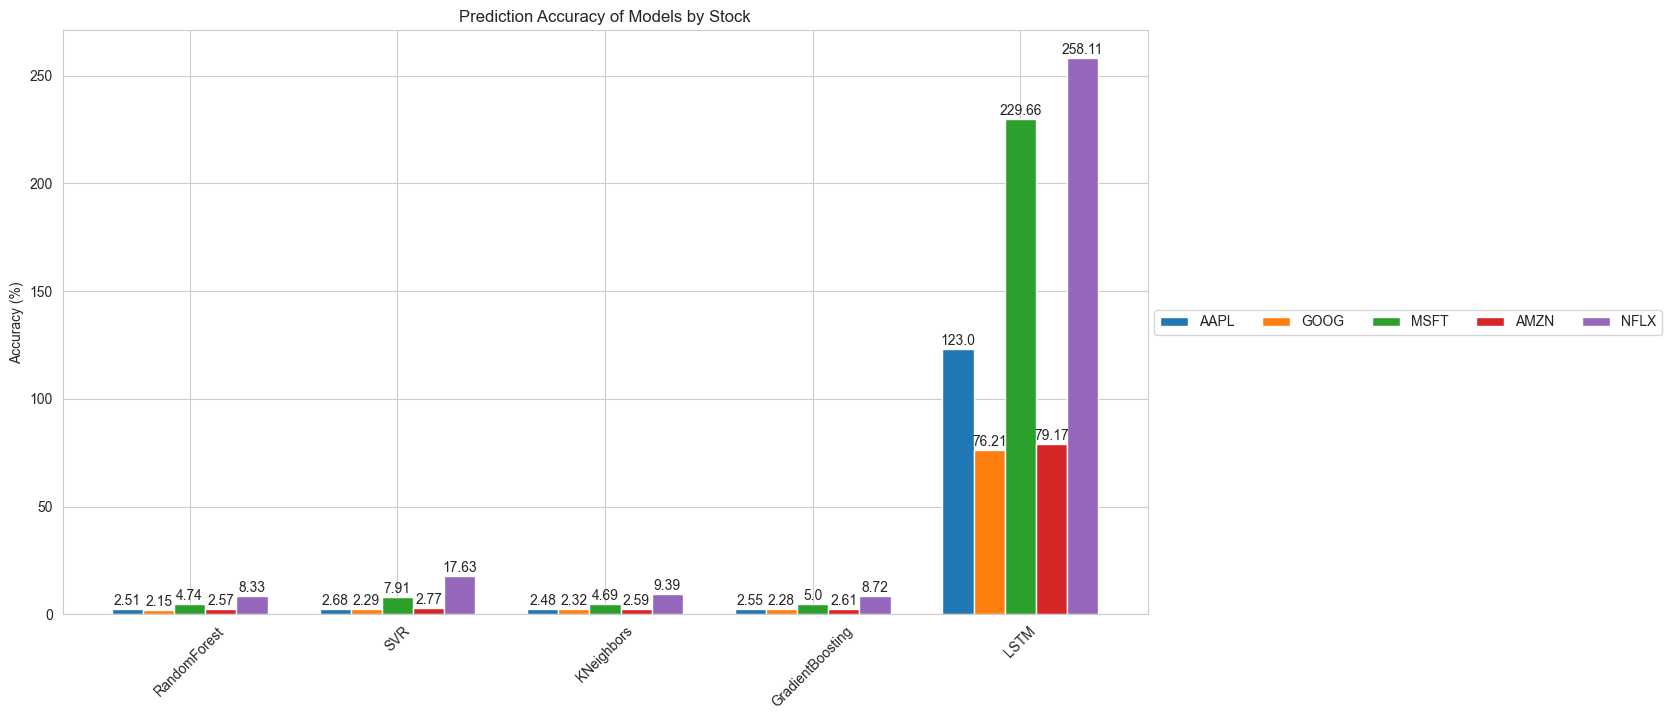

In [95]:
# Define colors for each ticker
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'NFLX']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Less intense colors

# Create a color dictionary
color_dict = dict(zip(tickers, colors))

# Convert the results dictionary to a pandas DataFrame
df_results = pd.DataFrame(MAE_results)

# Transpose the DataFrame so that the models are the columns and tickers are the index
df_results = df_results.T

# Define the positions for the bars
bar_width = 0.15
indices = np.arange(len(df_results.columns))

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(14, 8))  # Increase the figure size

# For each model, create a bar plot at a different position
for i, (ticker, accuracies) in enumerate(df_results.iterrows()):
    bars = ax.bar(indices + i*bar_width, accuracies, bar_width, label=ticker, color=color_dict[ticker])
    
    # Add labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

# Label the x-axis with the ticker symbols
ax.set_xticks(indices + bar_width * (len(df_results.index)-1) / 2)
ax.set_xticklabels(df_results.columns, rotation=45)  # Rotate the x-axis labels

# Add the legend and labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=len(tickers))  # Move the legend to the right side
plt.ylabel('Mean absolute error')
plt.title('Prediction Errors of Models by Stock')
plt.subplots_adjust(bottom=0.15)  # Adjust the bottom of the plot to prevent overlap
plt.show()




From the correlation heatmap, it becomes clear that Microsoft and Amazon share a stronger correlation, and in general
Microsoft maintains a strongest pairwise aggregate correlations compared to the rest of the 'FAANG' companies. Though perhaps expected, it is noteworthy that all five companies pairwise have moderate to strong positive correlation.

## Determining Value from Risk vs. Expected Return
Now we address the question of risk in buying stocks to compare these five companies.

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define a function to plot stock data
def plot_stock_data(df, ticker):
    plt.figure(figsize=(15, 8))
    df['Adj Close'].plot()
    plt.title(f'{ticker} - Adj Close')
    plt.show()

    plt.figure(figsize=(15, 8))
    df['Volume'].plot()
    plt.title(f'{ticker} - Volume')
    plt.show()

    df[['Adj Close', 'MAvg for 10 days', 'MAvg for 25 days', 'MAvg for 50 days']].plot(figsize=(15, 8))
    plt.title(f'{ticker} - Moving Averages')
    plt.show()

    plt.figure(figsize=(15, 8))
    sns.histplot(df['Daily Return'].dropna(), bins=100, color='red')
    plt.title(f'{ticker} - Daily Return')
    plt.show()

# Define a function to compute and plot correlations
def compute_and_plot_correlations(df):
    correlation_matrix = df.corr()

    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

    plt.title('Correlation Matrix of Daily Returns', fontsize=15)
    plt.show()

# Define a function to train and evaluate models
def train_and_evaluate_models(df, ticker):
    accuracy_results = {}

    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    models = {
        'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2,
                                               min_samples_leaf=1, max_depth=10, bootstrap=True),
        'SVR': SVR(kernel='rbf'),
        'KNeighbors': KNeighborsRegressor(n_neighbors=2),
        'GradientBoosting': GradientBoostingRegressor(),
        'LSTM': Sequential([
            LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
            LSTM(50),
            Dense(1)
        ])
    }

    for model_name, model in models.items():
        model.fit(x_train, y_train)
        predict = model.predict(x_test)
        accuracy = round(100 - np.mean(100 * (abs(predict - y_test) / y_test)), 2)
        accuracy_results[model_name] = accuracy

    return accuracy



TypeError: compute_and_plot_correlations() missing 1 required positional argument: 'df'

From this plot we can see that Microsoft has the highest expected return and the lowest risk -- a sign that it is the best stock to buy at the moment. With its overhaul of its cloud computing sectors and high-profile acquisitions, Microsoft stock is a clear winner here. Netflix's performance is more concerning as it has virtually zero positive expected return along with the highest risk.

We want to model an additional value-at-risk metric in order to assess the value at each risk confidence interval for these 5 companies. Let's try this two ways: bootstrapping and using Monte Carlo-GBM, with Google.

In [ ]:
rets_compr.head()

,AAPL,AMZN,GOOG,MSFT,NFLX
Date,,,,,
2018-07-16,NaN,NaN,NaN,NaN,NaN
2018-07-17,0.002818,0.011764,0.012620,0.009978,-0.052437
2018-07-18,-0.005462,-0.000548,-0.002436,-0.007865,-0.011463
2018-07-19,0.007731,-0.016251,-0.007459,-0.006864,-0.029057
2018-07-20,-0.002275,0.000403,-0.001727,0.017911,-0.008731


In [24]:
rets_compr['GOOG'].quantile(q=0.05)


-0.03345775889221053

In [25]:
rets_compr['GOOG'].quantile(q=0.01)



-0.058353149390987624

From the empirical quantiles given for both confience intervals, we know that the worst possible loss will not exceed 2.65 percent with 95% confidence and 5.04 percent with 99% confidence.

## Predicting Future Risk and Value of Stocks
We run the Monte Carlo Method on the GBM model to assess the stability and predict the future risk of our stocks. For this component, I'll be analyzing Google's stock.

In [27]:
days = 365

#delta t
dt = 1/365

mu = rets_compr.mean()['GOOG']

sigma = rets_compr.std()['GOOG']


def stock_monte_carlo(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1,days):
        
        #Shock and drift formulas taken from the Monte Carlo formula
        shock[x] = np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt))
        
        drift[x] = mu * dt
        
        #New price = Old price + Old price*(shock+drift)
        price[x] = price[x-1] + (price[x-1] * (drift[x]+shock[x]))
        
    return price


We’re going to run 100 Monte Carlo simulations of Google stocks. Here's the stock's opening values again.



In [28]:
GOOG.head()

NameError: name 'GOOG' is not defined

Text(0.5, 1.0, 'Monte Carlo Analysis for Google')

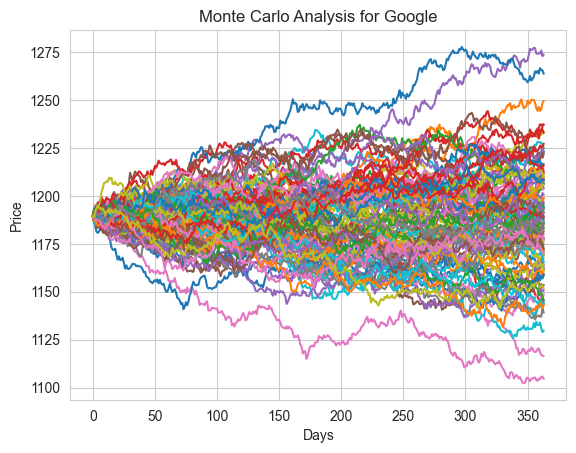

In [29]:
start_price = 1189.39 #Taken from above

for run in range(1,100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))

plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis for Google')

Text(0.5, 1.0, 'Final price distribution for Google Stock after 364 days')

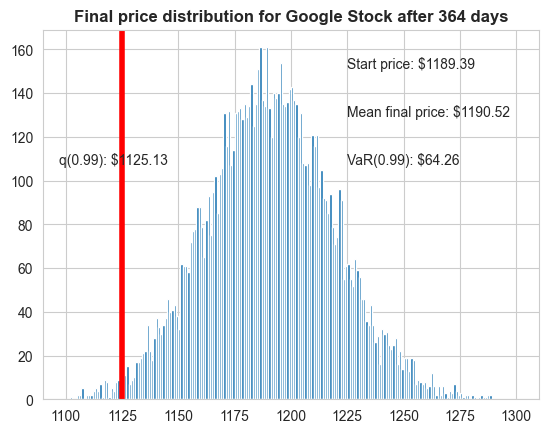

In [30]:
runs = 10000

simulations = np.zeros(runs)

for run in range(1,runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]
q = np.percentile(simulations,1)

plt.hist(simulations,bins=200,range = [1100,1300])

plt.figtext(0.6,0.8,s="Start price: $%.2f" %start_price)

plt.figtext(0.6,0.7,"Mean final price: $%.2f" % simulations.mean())

plt.figtext(0.6,0.6,"VaR(0.99): $%.2f" % (start_price -q,))

plt.figtext(0.15,0.6, "q(0.99): $%.2f" % q)

plt.axvline(x=q, linewidth=4, color='r')

plt.title(u"Final price distribution for Google Stock after %s days" %days, weight='bold')

Based off the histogram, we conclude that Google's stock price is very stable (only a $0.11 difference between start and mean final price). The value-at-risk of our investment is $46.42 for maximum low price of $1142.97 with 99% confidence, which is approximately a 3.9% risk compared to the 6.5% we achieved via bootstrapping. 